In [1]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
os.chdir('..')
from star_sample import Isochrones,StarSample
os.chdir('Data')
pkl_file = open('isochrones_high_lat.pkl', 'rb')

Isochrone_hl = pickle.load(pkl_file)
os.chdir('..')

In [2]:
os.chdir('Data')
pkl_file = open('high_lat_values.pkl', 'rb')

High_Latitude_sample = pickle.load(pkl_file)
os.chdir('..')

In [3]:
High_Latitude_sample.data['G']=High_Latitude_sample.data['phot_g_mean_mag']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5

In [4]:
High_Latitude_sample.data['K']=High_Latitude_sample.data['ks_m']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5
High_Latitude_sample.data['jk']=High_Latitude_sample.data['j_m']-High_Latitude_sample.data['ks_m']

In [5]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']>4.3].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']<4.9].reset_index(drop=True)

In [6]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['r_med_geo']<1000.0].reset_index(drop=True)


In [7]:
stacked_isochrones=Isochrone_hl.stack_isochrones()
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [8]:
import jax.numpy as jnp


In [9]:
stacked_isochrones=jnp.array(stacked_isochrones)

In [10]:
x_columns=High_Latitude_sample.data.columns
isoc_columns=Isochrone_hl.isochrones_list[0].columns

In [11]:

def column_index_2(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0]

In [12]:
x_columns2=['G','bp_rp','teff_gspphot']
def column_index(name):
    if name in x_columns2:
        return np.where(np.array(x_columns2)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] + len(x_columns2)

In [13]:
len(x_values)

27428

In [14]:
for i in range(len(x_values)):
    if(i%500==0):
        print(i)
    G=jnp.array(x_values[i][0,column_index_2('G')])
    C=jnp.array(x_values[i][0,column_index_2('bp_rp')])
    teffmeas=jnp.array(x_values[i][0,column_index_2('teff_gspphot')])
    
    ones=jnp.ones_like((stacked_isochrones[:,:,column_index('G')]))
    single_source=jnp.concatenate([(G*ones)[:,:,jnp.newaxis],(C*ones)[:,:,jnp.newaxis],(teffmeas*ones)[:,:,jnp.newaxis]],axis=-1)

    isochrone=jnp.concatenate([single_source,stacked_isochrones],axis=-1)
    truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
    truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
    truth=jnp.logical_and(truth_1,truth_2)


    a1=-1*isochrone[:,:,column_index('slopes')]
    b1=1.0
    c1=isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]-isochrone[:,:,column_index('Gaia_G_EDR3')]


    a2=-1*isochrone[:,:,column_index('p_slopes')]
    b2=1.0
    c2=isochrone[:,:,column_index('p_slopes')]*isochrone[:,:,column_index('bp_rp')]-isochrone[:,:,column_index('G')]


    x=(b1*c2-b2*c1)/(a1*b2-a2*b1)
    y=(a2*c1-a1*c2)/(a1*b2-a2*b1)

    sgn=jnp.sign((y-isochrone[:,:,column_index('G')])/(x-isochrone[:,:,column_index('bp_rp')]))
    
    d=jnp.sqrt((x-isochrone[:,:,column_index('bp_rp')])**2+(y-isochrone[:,:,column_index('G')])**2)
    
    

   
    idx=(jnp.argmin(jnp.nan_to_num(jnp.abs(d/truth.reshape(d.shape)),nan=1e5),-1))
    #sgn=jnp.take(sgn,indices=idx)
    #sgn=jnp.array([sgn[i,idx[i]] for i in range(len(idx))])
    #d=jnp.take(d,indices=idx)*sgn
    #d=jnp.array([d[i,idx[i]] for i in range(len(idx))])*sgn

    #x_ints=jnp.take(x,indices=idx)#jnp.array([x[i,idx[i]] for i in range(len(idx))])     
    #y_ints=jnp.take(y,indices=idx)#jnp.array([y[i,idx[i]] for i in range(len(idx))])    
    #logg=jnp.take(isochrone[:,:,column_index('logg')],indices=idx)#jnp.array([isochrone[i,idx[i],column_index('logg')] for i in range(len(idx))])
    teff=jnp.take_along_axis(isochrone[:,:,column_index('logteff')],idx.reshape(len(isochrone[:,:,column_index('logteff')]),1),axis=-1)
    #teff=jnp.take(isochrone[:,:,column_index('logteff')],indices=idx)#jnp.array([isochrone[i,idx[i],column_index('logteff')] for i in range(len(idx))])
    #feh=jnp.take(isochrone[:,:,column_index('feh')],indices=idx)#jnp.array([isochrone[i,idx[i],column_index('feh')] for i in range(len(idx))])

    pt=jnp.argmin(jnp.abs(teff-jnp.log10(teffmeas)))
    #pt=jnp.argmin(jnp.abs(teff-jnp.log10(teffmeas)))

    #pt=np.argmin(np.abs(feh-(isochrone[0,0,column_index('feh_calib')].numpy()))) 
    if i == 0:
        stack=jnp.array(isochrone[pt,idx[pt],:])[jnp.newaxis,:]
    else: 
        stack=jnp.concatenate([stack,jnp.array(isochrone[pt,idx[pt],:])[jnp.newaxis,:]])

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000


# Try do without a loop

In [15]:
G=jnp.array(x_values[:,0,column_index_2('G')])
C=jnp.array(x_values[:,0,column_index_2('bp_rp')])
teffmeas=jnp.array(x_values[:,0,column_index_2('teff_gspphot')])

In [16]:
G.shape

(27428,)

In [17]:
#jnp.moveaxis(idx, -1, 0)

In [18]:
len([tuple(jnp.moveaxis(idx, -1, 0))])

1

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

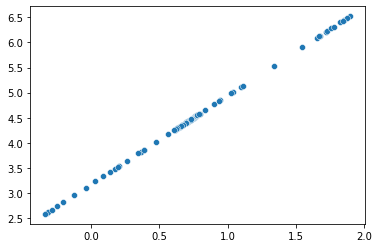

In [19]:
sn.scatterplot(x[0],y[0])

In [20]:
ag=jnp.array(x_values[:,:,column_index_2('G')][:,0])-stack[:,column_index('Gaia_G_EDR3')]

In [21]:

#E=stack[:,column_index('bp_rp')]-stack[:,column_index('BPRP')]
#d=stack[:,column_index('r_med_geo')]
High_Latitude_sample.data['ag2']=ag
#High_Latitude_sample.data['E']=E

<AxesSubplot:>

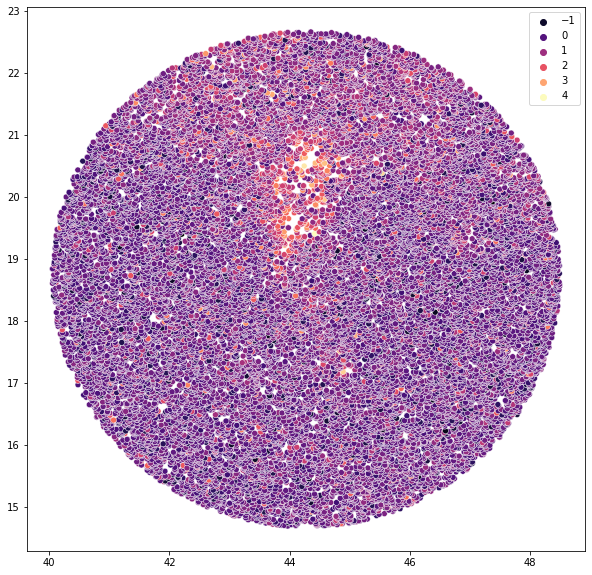

In [22]:
plt.figure(figsize=(10,10))
sn.scatterplot(x=jnp.array(x_values[:,:,column_index_2('ra')][:,0]),y=jnp.array(x_values[:,:,column_index_2('dec')][:,0]),hue=ag,s=35,palette='magma')

(-1.5, 4.0)

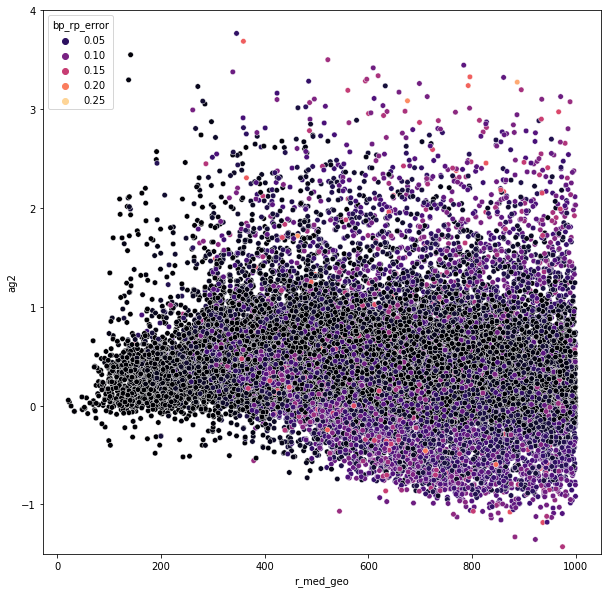

In [23]:
plt.figure(figsize=(10,10))
sn.scatterplot(data=High_Latitude_sample.data,x='r_med_geo',y='ag2',hue='bp_rp_error',palette='magma',s=30)
plt.ylim(-1.5,4)

# Posterior stuff!

In [24]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

rng_key = random.PRNGKey(0)
assert numpyro.__version__.startswith("0.10.1")
import math

m=math.atan(1.77)


In [29]:
m=math.atan(1.77)


g_obs=x_values[:,0,column_index_2('phot_g_mean_mag')]
g_obs_error=x_values[:,0,column_index_2('phot_g_mean_mag_error')]
C_obs=x_values[:,0,column_index_2('bp_rp')]
C_obs_error=x_values[:,0,column_index_2('bp_rp_error')]

teff_values=x_values[:,0,column_index_2('teff_gspphot')]
teff_error=0.5

parallax_obs=x_values[:,0,column_index_2('parallax')]
parallax_obs_error=x_values[:,0,column_index_2('parallax_error')]

n_samples=len(x_values)
n_samples

27428

In [32]:
plx_zp=-0.029

def model(g_obs,g_obs_error,C_obs,C_obs_error,parallax_obs,parallax_obs_error,teff_values,teff_error,n_samples):
    log_L = numpyro.sample("log_L", dist.Normal(np.log(370.0), 2.0))
    L = numpyro.deterministic("L", jnp.exp(log_L))
    with numpyro.plate("plate_i", n_samples):
        d_dist = dist.TransformedDistribution(
            dist.Chi2(6),
            dist.transforms.AffineTransform(
                0.0, 0.5 * L, domain=dist.constraints.positive
            ),
        )
        d=numpyro.sample('d',d_dist,rng_key=rng_key)
        ag=numpyro.sample('ag',dist.Uniform(low=0,high=5),rng_key=rng_key)       
        teff=numpyro.sample('teff',dist.TransformedDistribution(dist.Normal(0.0,1.0),dist.transforms.AffineTransform(2500.0,7500.0))) #could be anything

    for i in range(len(x_values)):
        print(i)
        G=jnp.array(x_values[i][0,column_index_2('G')])
        C=jnp.array(x_values[i][0,column_index_2('bp_rp')])
        teffmeas=jnp.array(x_values[i][0,column_index_2('teff_gspphot')])
        
        ones=jnp.ones_like((stacked_isochrones[:,:,column_index('G')]))
        single_source=jnp.concatenate([(G*ones)[:,:,jnp.newaxis],(C*ones)[:,:,jnp.newaxis],(teffmeas*ones)[:,:,jnp.newaxis]],axis=-1)

        isochrone=jnp.concatenate([single_source,stacked_isochrones],axis=-1)
        truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
        truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
        truth=jnp.logical_and(truth_1,truth_2)


        a1=-1*isochrone[:,:,column_index('slopes')]
        b1=1.0
        c1=isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]-isochrone[:,:,column_index('Gaia_G_EDR3')]


        a2=-1*isochrone[:,:,column_index('p_slopes')]
        b2=1.0
        c2=isochrone[:,:,column_index('p_slopes')]*isochrone[:,:,column_index('bp_rp')]-isochrone[:,:,column_index('G')]


        x=(b1*c2-b2*c1)/(a1*b2-a2*b1)
        y=(a2*c1-a1*c2)/(a1*b2-a2*b1)

        
        d=jnp.sqrt((x-isochrone[:,:,column_index('bp_rp')])**2+(y-isochrone[:,:,column_index('G')])**2)
        idx=(jnp.argmin(jnp.nan_to_num(jnp.abs(d/truth.reshape(d.shape)),nan=1e5),-1))
        teff=jnp.take_along_axis(isochrone[:,:,column_index('logteff')],idx.reshape(len(isochrone[:,:,column_index('logteff')]),1),axis=-1)

        pt=jnp.argmin(jnp.abs(teff-jnp.log10(teffmeas)))

        if i == 0:
            stack=jnp.array(isochrone[pt,idx[pt],:])[jnp.newaxis,:]
        else: 
            stack=jnp.concatenate([stack,jnp.array(isochrone[pt,idx[pt],:])[jnp.newaxis,:]])
    #age_list=np.array([9.0])
    #stacked_isochrones=Isochrone_hl.stack_isochrones_subsample(feh.static(),age_list)
    G=jnp.array(stack[:,:,column_index('Gaia_G_EDR3')])
    G=jnp.nan_to_num(G,nan=jnp.inf)
    C=jnp.array(stack[:,:,column_index('BPRP')])
    C=jnp.nan_to_num(C,nan=jnp.inf)
    C=numpyro.deterministic("C",C+ag[:,jnp.newaxis]/1.77)
    g=numpyro.deterministic(
            "g", G +ag[:,jnp.newaxis]+5.0*jnp.log10(d[:,jnp.newaxis])-5.0
        )

    

    with numpyro.plate("data", n_samples):
        plx = numpyro.deterministic("plx", 1000.0 / d + plx_zp)
        numpyro.sample("plx_obs", dist.Normal(plx, parallax_obs_error), obs=parallax_obs)    
        numpyro.sample("teff_obs", dist.Normal(teff, teff_error), obs=teff_values)
        numpyro.sample('g_obs',dist.MultivariateNormal(g,g_obs_error[:,jnp.newaxis,jnp.newaxis]*jnp.eye(g.shape[-1])),obs=g_obs[:,jnp.newaxis]*jnp.ones(g.shape[-1])[jnp.newaxis,:])
        numpyro.sample('C_obs',dist.MultivariateNormal(C,C_obs_error[:,jnp.newaxis,jnp.newaxis]*jnp.eye(g.shape[-1])),obs=C_obs[:,jnp.newaxis]*jnp.ones(C.shape[-1])[jnp.newaxis,:])



In [33]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
mcmc.run(rng_key, g_obs,g_obs_error,C_obs,C_obs_error,parallax_obs,parallax_obs_error,teff_values,teff_error,n_samples)

posterior_samples = mcmc.get_samples()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: Too many indices for array: 3 non-None/Ellipsis indices for dim 2.